This notebook is used to find the best model for the dataset using auto_sklearn.

Tested in a clean environment with Python 3.10.9

These are the packages we used

In [1]:
# To perform data manipulation
%pip install pandas==1.5.2

# To monitor progress in long tasks
%pip install tqdm==4.64.1

# Pyarrow is used by pandas to save/load parquet files
%pip install pyarrow==10.0.1

# To process natural text
%pip install nltk==3.8.1

# We will try to find the best model for the dataset using auto-sklearn
%pip install auto-sklearn==0.15.0

# To visualize confusion matrix and plot other data
%pip install seaborn==0.12.2
%pip install matplotlib==3.6.2

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Now let's import the necessary modules

In [2]:
import pandas as pd # For data processing

import nltk # For text processing
nltk.download('stopwords') # Stop words
nltk.download('punkt') # Tokenizer
english_stop_words = set(nltk.corpus.stopwords.words('english')) # Saving the stopwords in a list

from tqdm import tqdm # To monitor progress in large tasks
tqdm.pandas() # Configure tqdm to work with pandas

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer # To make sklearn work with text features
from sklearn.model_selection import train_test_split # To split train/test data
from sklearn.utils import resample # To balance the dataset

import autosklearn.classification # To find a model automatically
from sklearn.metrics import classification_report # To determine the quality of our models
from sklearn.metrics import confusion_matrix  # To determine the quality of our models
import seaborn as sns # To see the confusion matrix
import matplotlib.pyplot as plt # To see the confusion matrix

[nltk_data] Downloading package stopwords to /home/daniel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/daniel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Let's load our dataset, making sure there are no duplicated rows

In [3]:
df_commits_annotated = pd.read_parquet('commits_annotated.parquet.gzip')
print(f'Number of rows: {df_commits_annotated.shape[0]}')
print(f'Number of duplicated: {df_commits_annotated.revision_hash.duplicated().sum()}')
df_commits_annotated.head()

Number of rows: 452284
Number of duplicated: 0


,index,_id,revision_hash,message,isBugfix
0,0,5bef24dc83ad2f56ca1ca7cd,64185d21b51d1ed32c419f443f804ae2e09ee5f8,The the patrol.,False
1,1,5bef24dd83ad2f56ca1ca7d3,37ab026c576c8841f378cc2376ca02c478567e84,Cleanup in commons-rdf-rdf4j to close PMD and ...,False
2,2,5bef24dd83ad2f56cb1ca7cd,092c465f996f3a4a6acf3f65aeb76f768e702289,COMMONSRDF-49: Make AbstractRDFParser serializ...,False
3,3,5bef24dd83ad2f56cc1ca7cd,6123c7308ed533b870370c6a234ce140368ccc4e,ensure site build works with newest checkstyle...,False
4,4,5bef24dd83ad2f56cc1ca7d4,25af8121afb778efa20d73e1f10c073ad1917e59,[maven-release-plugin] prepare for next develo...,False


We only need columns 'message' and 'isBugfix'. Let's drop the others

In [4]:
df_commits_annotated.drop(columns=['_id','revision_hash'], inplace=True)
df_commits_annotated.head()

,index,message,isBugfix
0,0,The the patrol.,False
1,1,Cleanup in commons-rdf-rdf4j to close PMD and ...,False
2,2,COMMONSRDF-49: Make AbstractRDFParser serializ...,False
3,3,ensure site build works with newest checkstyle...,False
4,4,[maven-release-plugin] prepare for next develo...,False


Now let's try to balance the dataset. As it can be seen, it is highly imbalanced.

In [5]:
df_commits_count = df_commits_annotated['isBugfix'].value_counts()
df_commits_count

False    449379
True       2905
Name: isBugfix, dtype: int64

Let's downsample the majority class. It's okay, since we still have almost 3K "True" values.

In [6]:
df_majority = df_commits_annotated[df_commits_annotated.isBugfix==False]
df_minority = df_commits_annotated[df_commits_annotated.isBugfix==True]

count_minority = df_commits_count[1] # Number of elements in minority class

df_majority_downsampled = resample(df_majority,
                                    replace=False,
                                    n_samples=count_minority,
                                    random_state=42)

df_commits_annotated = pd.concat([df_majority_downsampled, df_minority])

df_commits_annotated['isBugfix'].value_counts()

False    2905
True     2905
Name: isBugfix, dtype: int64

Now let's preprocess our text. First, we will lowercase and remove stopwords. This will be our 'input_feature' column

In [7]:
def lower_case_and_remove_stopwords(text):
    return ' '.join([word for word in nltk.tokenize.word_tokenize(text) if word not in (english_stop_words)])

df_commits_annotated['input_feature'] = df_commits_annotated['message']\
    .str.lower().progress_apply(lower_case_and_remove_stopwords)
df_commits_annotated.head()


100%|██████████| 5810/5810 [00:02<00:00, 2572.83it/s]


,index,message,isBugfix,input_feature
151859,151859,Update installation for impatient\n,False,update installation impatient
332572,332572,Added example for using the reverse mapping to...,False,added example using reverse mapping tool git-s...
196656,196656,PDFBOX-2883: remove COSDocument constructors u...,False,pdfbox-2883 : remove cosdocument constructors ...
395182,395182,Added #else formatting test.\nPR:\nObtained fr...,False,added # else formatting test . pr : obtained :...
141552,141552,KAFKA-3740: Part I: expose StreamConfig proper...,False,kafka-3740 : part : expose streamconfig proper...


Now our 'isBugfix' column needs to be converted from boolean to int: True=1, False=0. This will be our 'target' column

In [8]:
df_commits_annotated['target'] = df_commits_annotated['isBugfix']\
    .progress_apply(lambda x: 1 if x else 0)
df_commits_annotated.head()

100%|██████████| 5810/5810 [00:00<00:00, 607597.33it/s]


,index,message,isBugfix,input_feature,target
151859,151859,Update installation for impatient\n,False,update installation impatient,0
332572,332572,Added example for using the reverse mapping to...,False,added example using reverse mapping tool git-s...,0
196656,196656,PDFBOX-2883: remove COSDocument constructors u...,False,pdfbox-2883 : remove cosdocument constructors ...,0
395182,395182,Added #else formatting test.\nPR:\nObtained fr...,False,added # else formatting test . pr : obtained :...,0
141552,141552,KAFKA-3740: Part I: expose StreamConfig proper...,False,kafka-3740 : part : expose streamconfig proper...,0


Now let's split the dataset into train and test, transforming the textual column into vectors in the way.

We use a simple CountVectorizer first, and also a TF-IDF vectorizer. The TF-IDF Vectorizer parameters were copied from the results of [another notebook](find_vectorizer_parameters.ipynb)

In [9]:
y = df_commits_annotated['target']

vect_count = CountVectorizer()
X_count = vect_count.fit_transform(df_commits_annotated['input_feature'])
X_train_count, X_test_count, y_train_count, y_test_count = train_test_split(X_count, y, test_size=0.33, random_state=42)

vect_tfidf = TfidfVectorizer(encoding='latin-1', max_df=0.23622995216793718,
                max_features=920, min_df=2, ngram_range=(1, 3),
                sublinear_tf=True, token_pattern='\\w{1,}')
X_tfidf = vect_tfidf.fit_transform(df_commits_annotated['input_feature'])
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y, test_size=0.33, random_state=42)



Finally we can ask autosklearn to find the best model with each vectorizer. First with count vectorizer, and next with TF-IDF

In [10]:
clf_count = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=3600,
    memory_limit=8192,
    metric=autosklearn.metrics.f1)
clf_count.fit(X_train_count, y_train_count)

AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      memory_limit=8192, metric=f1, per_run_time_limit=360)

In [11]:
clf_tfidf = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=3600,
    memory_limit=8192,
    metric=autosklearn.metrics.f1)
clf_tfidf.fit(X_train_tfidf, y_train_tfidf)

AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      memory_limit=8192, metric=f1, per_run_time_limit=360)

Which models were selected?

In [19]:
clf_count.show_models()

{7: {'model_id': 7,
  'rank': 1,
  'cost': 0.06987227648384675,
  'ensemble_weight': 0.02,
  'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice at 0x7f89fe683490>,
  'balancing': Balancing(random_state=1, strategy='weighting'),
  'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice at 0x7f89fe6833d0>,
  'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice at 0x7f89fe683f70>,
  'sklearn_classifier': RandomForestClassifier(criterion='entropy', max_features=1278,
                         min_samples_leaf=12, min_samples_split=19,
                         n_estimators=512, n_jobs=1, random_state=1,
                         warm_start=True)},
 15: {'model_id': 15,
  'rank': 2,
  'cost': 0.042944785276073705,
  'ensemble_weight': 0.12,
  'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice at 0x7f89ff340040>,
  'balancing': Bala

In [18]:
clf_tfidf.show_models()

{2: {'model_id': 2,
  'rank': 1,
  'cost': 0.04719101123595515,
  'ensemble_weight': 0.02,
  'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice at 0x7f89fe1786d0>,
  'balancing': Balancing(random_state=1),
  'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice at 0x7f8a8923e1a0>,
  'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice at 0x7f8a89d68b80>,
  'sklearn_classifier': RandomForestClassifier(max_features=30, n_estimators=512, n_jobs=1,
                         random_state=1, warm_start=True)},
 24: {'model_id': 24,
  'rank': 2,
  'cost': 0.041474654377880116,
  'ensemble_weight': 0.02,
  'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice at 0x7f89ff341a50>,
  'balancing': Balancing(random_state=1),
  'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice at 0x7f8

Let's see our classification scores

In [20]:
y_pred_count = clf_count.predict(X_test_count)
print(classification_report(y_test_count, y_pred_count))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       978
           1       0.96      0.98      0.97       940

    accuracy                           0.97      1918
   macro avg       0.97      0.97      0.97      1918
weighted avg       0.97      0.97      0.97      1918



In [15]:
y_pred_tfidf = clf_tfidf.predict(X_test_tfidf)
print(classification_report(y_test_tfidf, y_pred_tfidf))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       978
           1       0.94      0.99      0.96       940

    accuracy                           0.96      1918
   macro avg       0.96      0.96      0.96      1918
weighted avg       0.96      0.96      0.96      1918



What about the errors? Let's check the confusion matrix

<AxesSubplot: >

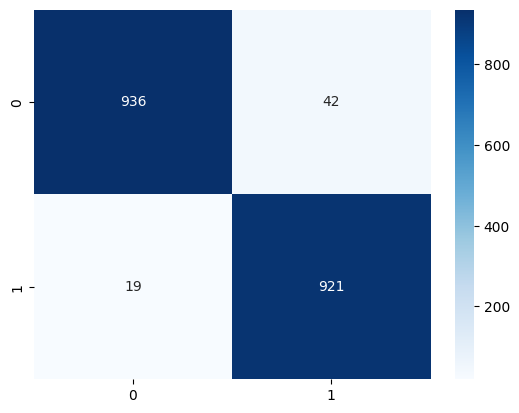

In [16]:
cf_matrix_count = confusion_matrix(y_test_count, y_pred_count)
sns.heatmap(cf_matrix_count, annot=True, fmt='d', cmap='Blues')

<AxesSubplot: >

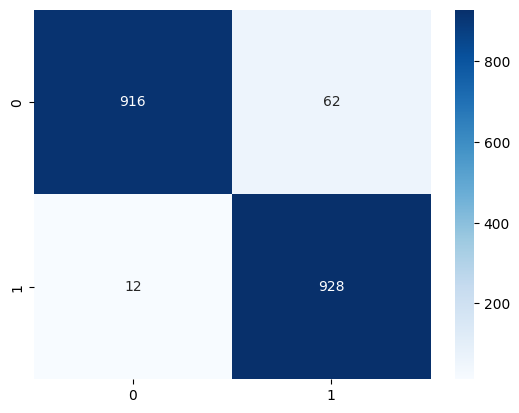

In [17]:
cf_matrix_tfidf = confusion_matrix(y_test_tfidf, y_pred_tfidf)
sns.heatmap(cf_matrix_tfidf, annot=True, fmt='d', cmap='Blues')